# 2D Ising Ferromagnet — Fast vs Slow Cooling (Simulated Annealing / Metropolis)

This notebook reproduces two snapshots similar to the “amorphous/disordered” vs “more ordered” figures:
- **Fast cooling (quench)**: few temperature steps, little equilibration  
- **Slow cooling (anneal)**: many temperature steps, more equilibration  

We simulate a 2D Ising ferromagnet with periodic boundary conditions and Metropolis single-spin flips.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(7)


## Metropolis sampler for the 2D Ising model

Spins live on an L×L grid: \(s_{x,y} \in \{-1,+1\}\).

Energy (nearest-neighbor, ferromagnetic):
\[
E(s) = -J \sum_{\langle i,j\rangle} s_i s_j - h \sum_i s_i
\]

We use local energy change for flipping one spin:
\[
\Delta E = 2 s_{x,y} \left(J \sum_{\text{nn}} s_{\text{nn}} + h \right)
\]


In [2]:
def ising_metropolis(L, schedule, sweeps_per_T, J=1.0, h=0.0, rng=None):
    """2D ferromagnetic Ising model (periodic BC) with Metropolis updates.

    Args:
        L: lattice size (LxL)
        schedule: iterable of temperatures (high -> low)
        sweeps_per_T: number of sweeps (L*L updates) per temperature
        J: coupling (J>0 ferromagnetic)
        h: external field
        rng: numpy RNG

    Returns:
        spins: ndarray of shape (L, L) with values ±1
    """
    if rng is None:
        rng = np.random.default_rng()

    spins = rng.choice([-1, 1], size=(L, L))

    for T in schedule:
        beta = 1.0 / T
        n_updates = sweeps_per_T * L * L

        xs = rng.integers(0, L, size=n_updates)
        ys = rng.integers(0, L, size=n_updates)

        for x, y in zip(xs, ys):
            s = spins[x, y]
            nn = (spins[(x+1) % L, y] + spins[(x-1) % L, y] +
                  spins[x, (y+1) % L] + spins[x, (y-1) % L])

            dE = 2.0 * s * (J * nn + h)

            if dE <= 0.0 or rng.random() < np.exp(-beta * dE):
                spins[x, y] = -s

    return spins


## Run two cooling schedules

Tune `L`, the number of temperature steps, and `sweeps_per_T` to get the visual texture you like.
- Larger `sweeps_per_T` and more temperature steps → **more ordered** final state.


In [5]:
# Lattice size (increase for finer textures; decrease for speed)
L = 140

T_start, T_end = 5.0, 0.7

# Fast cooling (quench): few temps, minimal equilibration
fast_schedule = np.linspace(T_start, T_end, 10)
spins_fast = ising_metropolis(L, fast_schedule, sweeps_per_T=1, rng=rng)

# Slow cooling: more temps, more equilibration per temp
slow_schedule = np.linspace(T_start, T_end, 120)
spins_slow = ising_metropolis(L, slow_schedule, sweeps_per_T=3, rng=rng)

spins_fast.shape, spins_slow.shape


((140, 140), (140, 140))

## Visualize and save the figures

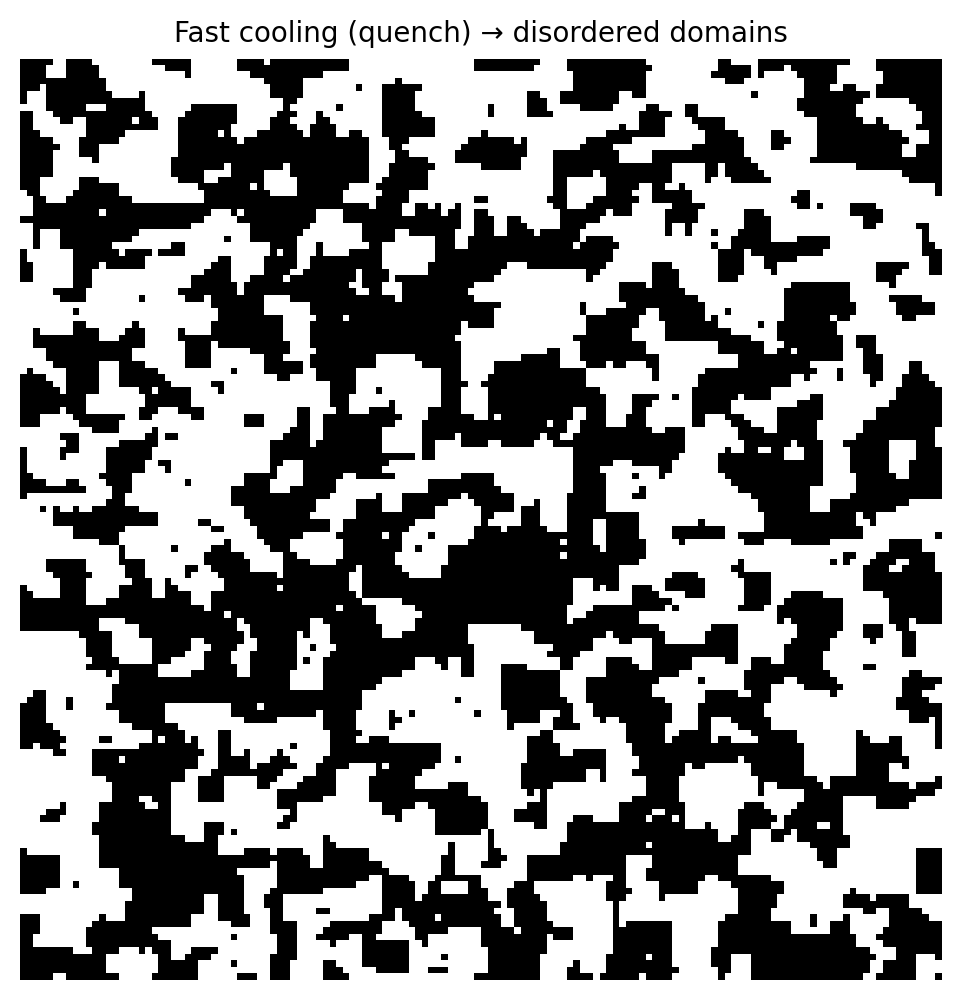

Saved figure to fast_cooling_amorphous_like.png


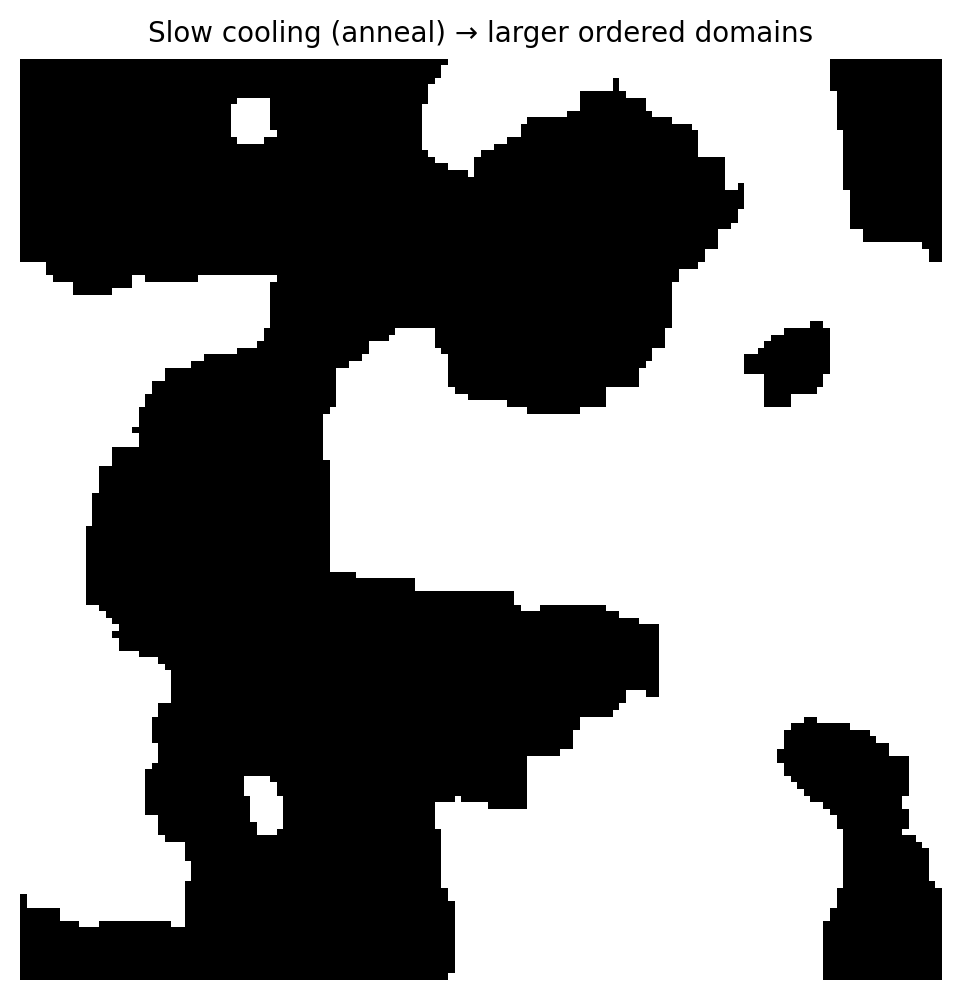

Saved figure to slow_cooling_ordered_like.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9.6, 4.8), dpi=200)
plots = [
    (spins_fast, "Fast cooling (quench) → disordered domains"),
    (spins_slow, "Slow cooling (anneal) → larger ordered domains"),
]

for ax, (spins, title) in zip(axes, plots):
    ax.imshow(spins, cmap="gray", interpolation="nearest")
    ax.set_title(title, fontsize=10)
    ax.axis("off")

fig.tight_layout(pad=0.2)
plt.show()

## Notes

- To make the slow-cooling image **more crystalline**:
  - increase `sweeps_per_T` (e.g., 5–10), and/or
  - decrease `T_end` (e.g., 0.5)

## Extension
- To get a more “glassy / frustrated” look, switch to a **spin glass** by making couplings \(J_{ij}\) random ±1.
